[Tutorial on jupyter, python, and data](https://www.dataquest.io/blog/jupyter-notebook-tutorial/)

In [77]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob

sns.set(style="darkgrid")


In [78]:
def categorize_angles_into_quadrants(df, angle_column='angle_degrees', quadrant_column='quadrant'):
    """
    Transforms angles in degrees into quadrants (I, II, III, IV) and adds a 
    new column with the quadrant information to the DataFrame.

    Args:
        df: Pandas DataFrame containing an angle column.
        angle_column: Name of the column containing angles in degrees.  Defaults to 'angle_degrees'.
        quadrant_column: Name of the new column to store quadrant information. Defaults to 'quadrant'.

    Returns:
        Pandas DataFrame with the added quadrant column.  Returns the original DataFrame if the angle column is not found.
        Prints an error message if the angle column is not found.
    """

    if angle_column not in df.columns:
        print(f"Error: Angle column '{angle_column}' not found in DataFrame.")
        return df

    df[quadrant_column] = np.nan  # Initialize with NaN (for consistency with NaN angles)

    # Handle NaN angles directly
    nan_mask = df[angle_column].isna()

    # Vectorized operations for non-NaN angles
    valid_mask = ~nan_mask  # Invert the NaN mask

    angles = df.loc[valid_mask, angle_column].astype(float) % 360  # Vectorized modulo

    df.loc[valid_mask & (angles < 90), quadrant_column] = 'I'
    df.loc[valid_mask & (angles >= 90) & (angles < 180), quadrant_column] = 'II'
    df.loc[valid_mask & (angles >= 180) & (angles < 270), quadrant_column] = 'III'
    df.loc[valid_mask & (angles >= 270), quadrant_column] = 'IV'


    return df

In [79]:
def detect_flips(df, quadrant1_col, quadrant2_col, flip_col='flip_type'):
    """
    Detects horizontal, vertical, and double flips based on quadrant changes.

    Args:
        df: Pandas DataFrame containing two quadrant columns.
        quadrant1_col: Name of the first quadrant column.
        quadrant2_col: Name of the second quadrant column.
        flip_col: Name of the new column to store flip information. Defaults to 'flip_type'.

    Returns:
        Pandas DataFrame with the added flip_type column.  Returns original DataFrame if columns are not found.
        Prints error messages if columns are not found.
    """
    
    if quadrant1_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant1_col}' not found in DataFrame.")
        return df

    if quadrant2_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant2_col}' not found in DataFrame.")
        return df

    df[flip_col] = 'N'  # Initialize

    # Create boolean masks for each flip type (vectorized)
    h_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'II')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'III'))

    v_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'II'))

    b_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'II'))

    same_mask = df[quadrant1_col] == df[quadrant2_col]

    nan_mask = df[quadrant1_col].isna() | df[quadrant2_col].isna()

    # Apply masks (vectorized)
    df.loc[h_mask, flip_col] = 'H'
    df.loc[v_mask, flip_col] = 'V'
    df.loc[b_mask, flip_col] = 'B'
    df.loc[same_mask, flip_col] = 'N' # No flip if same
    df.loc[nan_mask, flip_col] = np.nan # NaN if any is NaN

    return df

In [91]:
df = pd.DataFrame()
for f in glob.glob('./SpeedAsRhythm/Partecipante??_a*.csv'):
    df = pd.concat([df, pd.read_csv(f)])
df.tail()
print(len(df))

560


In [92]:
df.columns = ['trial', 'soundSpeed', 'soundAngle', 'movSpeed', 'movAngle', 'soundStart', 'startDragTime', 'endDragTime', 'hInterval', 'vInterval']

In [93]:
df.dtypes

trial              int64
soundSpeed       float64
soundAngle       float64
movSpeed         float64
movAngle         float64
soundStart         int64
startDragTime      int64
endDragTime        int64
hInterval        float64
vInterval        float64
dtype: object

In [94]:
categorize_angles_into_quadrants(df, angle_column='soundAngle', quadrant_column='soundQuadrant');

In [97]:
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
detect_flips(df, 'soundQuadrant', 'movQuadrant', 'flip')

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,soundQuadrant,movQuadrant,flip
0,0,80.870975,71.951468,152.885731,71.378421,1740668747198,1740668754518,1740668755788,1197.334941,390.159289,I,I,N
1,1,151.133621,256.233490,136.104566,251.003346,1740668760290,1740668765500,1740668766922,834.152924,204.370689,III,III,N
2,2,42.441783,43.363572,92.867978,46.049256,1740668771423,1740668776276,1740668778355,972.268988,1029.455928,I,I,N
3,3,58.239970,293.224805,80.997022,295.106446,1740668782857,1740668792286,1740668794672,1306.259610,560.533122,IV,IV,N
4,4,42.483685,209.146088,59.267261,204.713177,1740668799173,1740668807419,1740668810688,808.528739,1449.893689,III,III,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,35,35.763170,146.935895,35.363815,136.254452,1740403598158,1740403602276,1740403607756,1000.944007,1537.549734,II,II,N
36,36,36.717788,311.816168,56.527662,330.255119,1740403612257,1740403616083,1740403619506,1225.424079,1096.277958,IV,IV,N
37,37,70.672153,73.211211,98.704312,78.459502,1740403624007,1740403627814,1740403629789,1469.632883,443.394580,I,I,N
38,38,69.971104,293.007658,91.635322,289.653824,1740403634291,1740403637613,1740403639722,1096.952422,465.801725,IV,IV,N


In [104]:
dfN = df.loc[df['flip'] == 'N']
print(len(dfN))

532


In [105]:
dfN.tail()

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,soundQuadrant,movQuadrant,flip
35,35,35.763170,146.935895,35.363815,136.254452,1740403598158,1740403602276,1740403607756,1000.944007,1537.549734,II,II,N
36,36,36.717788,311.816168,56.527662,330.255119,1740403612257,1740403616083,1740403619506,1225.424079,1096.277958,IV,IV,N
37,37,70.672153,73.211211,98.704312,78.459502,1740403624007,1740403627814,1740403629789,1469.632883,443.394580,I,I,N
38,38,69.971104,293.007658,91.635322,289.653824,1740403634291,1740403637613,1740403639722,1096.952422,465.801725,IV,IV,N
39,39,91.043553,215.659855,79.721234,217.046918,1740403644223,1740403646703,1740403649139,405.557894,565.228840,III,III,N


(array([20., 17., 35., 42., 31., 26., 21., 20., 18., 19., 17., 22., 20.,
        18., 10., 15.,  7., 12., 13.,  9.,  7., 15.,  7., 10.,  2.,  5.,
         7.,  6.,  6.,  3.,  5.,  7.,  4.,  4.,  4.,  8.,  3.,  4.,  2.,
         5.,  1.,  6.,  6.,  3.,  5.,  1.,  2.,  0.,  1.,  1.]),
 array([ 26.9229216 ,  29.71297086,  32.50302012,  35.29306939,
         38.08311865,  40.87316791,  43.66321717,  46.45326643,
         49.2433157 ,  52.03336496,  54.82341422,  57.61346348,
         60.40351274,  63.19356201,  65.98361127,  68.77366053,
         71.56370979,  74.35375905,  77.14380832,  79.93385758,
         82.72390684,  85.5139561 ,  88.30400536,  91.09405463,
         93.88410389,  96.67415315,  99.46420241, 102.25425168,
        105.04430094, 107.8343502 , 110.62439946, 113.41444872,
        116.20449799, 118.99454725, 121.78459651, 124.57464577,
        127.36469503, 130.1547443 , 132.94479356, 135.73484282,
        138.52489208, 141.31494134, 144.10499061, 146.89503987,
        149.

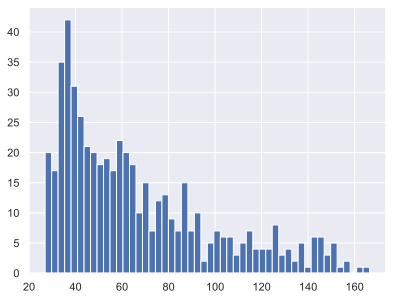

In [107]:
plt.hist(dfN.soundSpeed, bins=50)

(array([ 9., 20., 18., 24., 35., 23., 11., 10.,  0.,  2., 14., 19., 23.,
        22., 26., 16.,  8.,  0.,  0.,  6., 11., 24., 26., 27., 20., 10.,
         5.,  0.,  8., 10., 14., 22., 29., 14., 15., 11.]),
 array([  8.89438609,  18.35900388,  27.82362167,  37.28823947,
         46.75285726,  56.21747505,  65.68209284,  75.14671064,
         84.61132843,  94.07594622, 103.54056402, 113.00518181,
        122.4697996 , 131.93441739, 141.39903519, 150.86365298,
        160.32827077, 169.79288856, 179.25750636, 188.72212415,
        198.18674194, 207.65135974, 217.11597753, 226.58059532,
        236.04521311, 245.50983091, 254.9744487 , 264.43906649,
        273.90368429, 283.36830208, 292.83291987, 302.29753766,
        311.76215546, 321.22677325, 330.69139104, 340.15600883,
        349.62062663]),
 <BarContainer object of 36 artists>)

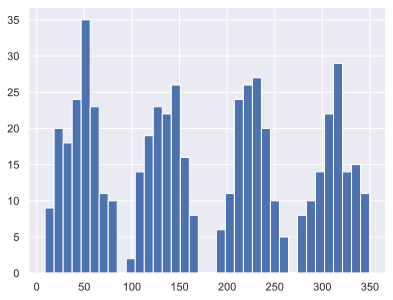

In [108]:
plt.hist(dfN.soundAngle,bins=36)

In [109]:
errAngle = dfN.movAngle - dfN.soundAngle

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  3.,  1.,  2.,  2.,  1.,  2.,
         3.,  0.,  8.,  4.,  6.,  2.,  5., 14., 10.,  9., 12., 17., 15.,
        22., 23., 22., 31., 25., 35., 31., 28., 24., 29., 20., 18., 12.,
        11., 13., 14., 10., 11.,  6.,  5.,  3.,  1.,  1.,  1.,  0.,  1.,
         3.,  2.,  0.,  1.,  3.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-47.64144663, -46.13416157, -44.62687652, -43.11959146,
        -41.61230641, -40.10502135, -38.59773629, -37.09045124,
        -35.58316618, -34.07588113, -32.56859607, -31.06131102,
        -29.55402596, -28.0467409 , -26.53945585, -25.03217079,
        -23.52488574, -22.01760068, -20.51031563, -19.00303057,
        -17.49574552, -15.98846046, -14.4811754 , -12.97389035,
        -11.46660529,  -9.95932024,  -8.45203518,  -6.94475013,
         -5.43746507,  -3.93018001,  -2.42289496,  -0.9156099 ,
          0.59167515,   2.09896021,   3.60624526,   5.11353032,
          6.62

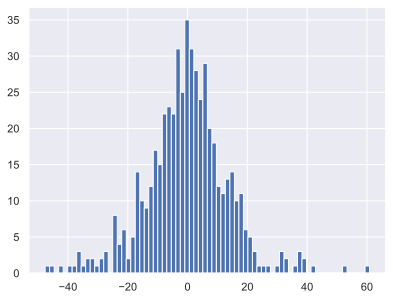

In [110]:
plt.hist(errAngle, bins=72)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   0.,   3.,   5.,
          1.,   3.,   6.,  12.,  17.,  36.,  79., 103., 106.,  69.,  36.,
         20.,  10.,   5.,   5.,   3.,   4.]),
 array([-471.13854769, -459.85332713, -448.56810657, -437.28288601,
        -425.99766544, -414.71244488, -403.42722432, -392.14200376,
        -380.85678319, -369.57156263, -358.28634207, -347.00112151,
        -335.71590094, -324.43068038, -313.14545982, -301.86023926,
        -290.57501869, -279.28979813, -268.00457757, -256.71935701,
        -245.43413644, -234.14891588, -222.86369532, -211.57847476,
        -200.2932542 , -189.00803363, -177.72281307, -166.43759251,
        -155.15237195, -143.86715138, -132.58193082, -121.29671026,
        -110.0114897 ,  -98.72626913,  -87.44104857,  -76.15582801,
         -64.87060745,  -53.58538688,  -42.300

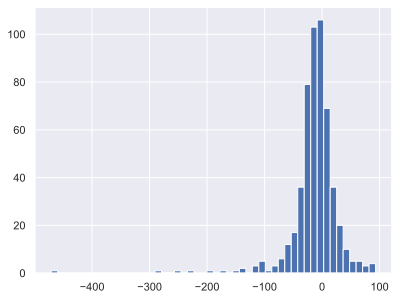

In [111]:
errSpeed = dfN.soundSpeed - dfN.movSpeed
plt.hist(errSpeed,bins=50)

Text(0.5, 1.0, 'start drag time as a function of angle error')

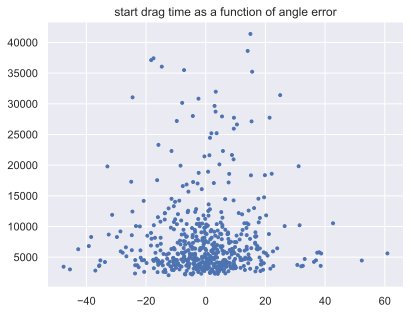

In [112]:
fig, ax = plt.subplots()
ax.plot(errAngle, dfN.startDragTime-dfN.soundStart, '.')
ax.set_title('start drag time as a function of angle error')

In [113]:
df = pd.DataFrame()
for f in glob.glob('./SpeedAsRhythm/Partecipante??_b*.csv'):
    df = pd.concat([df, pd.read_csv(f)])
df.tail()

,Trial,RandomSpeed,RandomAngle,UserSpeed,UserAngle,StartMovementTime,THor,TVer,THorSecond,TVerSecond,randomHorizontalInterval,randomVerticalInterval
35,35,36.675987,310.916721,33.930036,311.743148,1740576436627,1740576440230,1740576443609,1740576441558,1740576444794,1248.888774,1082.459504
36,36,81.134536,157.237111,66.810067,150.289183,1740576448610,1740576454290,1740576456307,1740576454807,1740576457213,400.987563,955.643937
37,37,67.116131,118.979082,59.280035,118.342407,1740576461028,1740576467741,1740576465658,1740576468807,1740576466233,922.591141,510.960389
38,38,38.574501,51.375601,33.754149,48.374435,1740576472611,1740576481713,1740576479195,1740576483051,1740576480384,1245.915490,995.470230
39,39,125.241258,237.627594,112.982507,239.553573,1740576486860,1740576491934,1740576490365,1740576492458,1740576490673,447.382672,283.615537


In [114]:
df.columns = ['trial', 'movSpeed', 'movAngle', 'tapSpeed', 'tapAngle', 'movStart', 'tapHor', 'tapVer', 'tapHor2', 'tapVer2', 'hInterval', 'vInterval']

In [115]:
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');

In [116]:
categorize_angles_into_quadrants(df, angle_column='tapAngle', quadrant_column='tapQuadrant');
detect_flips(df, 'movQuadrant', 'tapQuadrant', 'flip')

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,movQuadrant,tapQuadrant,flip
0,0,67.630091,204.893352,58.108788,209.298414,1740406877182,1740406880254,1740406881686,1740406880845,1740406882741,489.023282,1053.830619,III,III,N
1,1,116.163956,330.264994,59.013699,326.165356,1740406886556,1740406888880,1740406890207,1740406889492,1740406891120,297.416963,520.687994,IV,IV,N
2,2,32.099567,127.873400,57.845338,114.512986,1740406894923,1740406898020,1740406900841,1740406899270,1740406901411,1522.338226,1183.973303,II,II,N
3,3,87.895884,314.128369,66.484951,320.473763,1740406905221,1740406909324,1740406907738,1740406909909,1740406908447,490.203157,475.510789,IV,IV,N
4,4,80.776281,18.435490,58.844612,298.110952,1740406913723,1740406919488,1740406917874,1740406920570,1740406918452,391.487151,1174.424490,I,IV,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,35,36.675987,310.916721,33.930036,311.743148,1740576436627,1740576440230,1740576443609,1740576441558,1740576444794,1248.888774,1082.459504,IV,IV,N
36,36,81.134536,157.237111,66.810067,150.289183,1740576448610,1740576454290,1740576456307,1740576454807,1740576457213,400.987563,955.643937,II,II,N
37,37,67.116131,118.979082,59.280035,118.342407,1740576461028,1740576467741,1740576465658,1740576468807,1740576466233,922.591141,510.960389,II,II,N
38,38,38.574501,51.375601,33.754149,48.374435,1740576472611,1740576481713,1740576479195,1740576483051,1740576480384,1245.915490,995.470230,I,I,N


(array([17., 36., 35., 39., 35., 36., 19., 23., 23., 17., 20., 14., 18.,
        21., 17., 21., 15., 13.,  8., 11.,  9.,  5., 11.,  8.,  9.,  3.,
         6.,  9.,  6.,  2.,  8.,  2.,  8.,  5.,  3.,  5.,  8.,  3.,  1.,
         1.,  4.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([ 26.89503909,  30.09693549,  33.2988319 ,  36.5007283 ,
         39.70262471,  42.90452112,  46.10641752,  49.30831393,
         52.51021033,  55.71210674,  58.91400315,  62.11589955,
         65.31779596,  68.51969236,  71.72158877,  74.92348518,
         78.12538158,  81.32727799,  84.52917439,  87.7310708 ,
         90.9329672 ,  94.13486361,  97.33676002, 100.53865642,
        103.74055283, 106.94244923, 110.14434564, 113.34624205,
        116.54813845, 119.75003486, 122.95193126, 126.15382767,
        129.35572408, 132.55762048, 135.75951689, 138.96141329,
        142.1633097 , 145.36520611, 148.56710251, 151.76899892,
        154.97089532, 158.17279173, 161.37468814, 164.57658454,
        167.

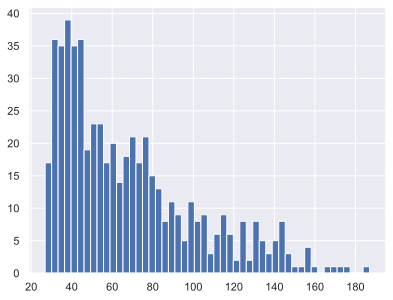

In [70]:
plt.hist(df.movSpeed, bins=50)

In [117]:
dfN = df.loc[df['flip'] == 'N']
print(len(dfN))

552


(array([ 9., 13., 21., 30., 19., 28., 20.,  5.,  0.,  2.,  8., 23., 31.,
        26., 19., 14.,  9.,  0.,  2., 14., 15., 19., 19., 17., 15., 17.,
         2.,  0.,  9., 23., 21., 28., 33., 16., 17.,  8.]),
 array([  8.28270145,  17.8333985 ,  27.38409555,  36.9347926 ,
         46.48548965,  56.0361867 ,  65.58688375,  75.1375808 ,
         84.68827785,  94.2389749 , 103.78967195, 113.340369  ,
        122.89106605, 132.4417631 , 141.99246015, 151.5431572 ,
        161.09385424, 170.64455129, 180.19524834, 189.74594539,
        199.29664244, 208.84733949, 218.39803654, 227.94873359,
        237.49943064, 247.05012769, 256.60082474, 266.15152179,
        275.70221884, 285.25291589, 294.80361294, 304.35430998,
        313.90500703, 323.45570408, 333.00640113, 342.55709818,
        352.10779523]),
 <BarContainer object of 36 artists>)

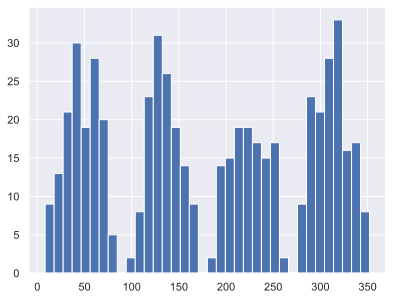

In [119]:
plt.hist(dfN.movAngle,bins=36)

In [121]:
errAngle = dfN.tapAngle - dfN.movAngle

(array([ 2.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  2.,  2.,  4.,
         1.,  1.,  3.,  3.,  7.,  8.,  8.,  6., 19., 19., 11., 14., 14.,
        16., 21., 23., 21., 20., 29., 27., 39., 14., 20., 23., 26., 18.,
        19., 18., 14.,  8., 11.,  7., 11.,  8.,  8.,  3.,  2.,  4.,  3.,
         1.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
         1.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([-43.07214903, -41.74214763, -40.41214623, -39.08214482,
        -37.75214342, -36.42214202, -35.09214062, -33.76213921,
        -32.43213781, -31.10213641, -29.772135  , -28.4421336 ,
        -27.1121322 , -25.7821308 , -24.45212939, -23.12212799,
        -21.79212659, -20.46212519, -19.13212378, -17.80212238,
        -16.47212098, -15.14211957, -13.81211817, -12.48211677,
        -11.15211537,  -9.82211396,  -8.49211256,  -7.16211116,
         -5.83210976,  -4.50210835,  -3.17210695,  -1.84210555,
         -0.51210414,   0.81789726,   2.14789866,   3.47790006,
          4.80

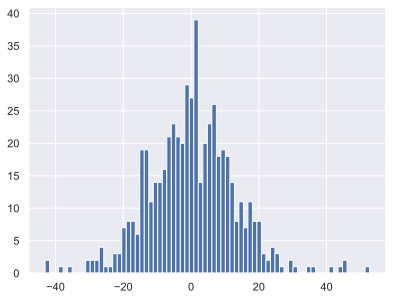

In [122]:
plt.hist(errAngle, bins=72)

(array([ 2.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  2.,  4.,  1.,  3.,  2.,
         4.,  9., 10.,  6., 21., 26., 31., 45., 61., 56., 47., 26., 36.,
        21., 14., 20., 14.,  9., 13., 10.,  5.,  6.,  7.,  7.,  6.,  5.,
         4.,  4.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([-78.43793091, -74.57102376, -70.70411661, -66.83720946,
        -62.97030231, -59.10339515, -55.236488  , -51.36958085,
        -47.5026737 , -43.63576655, -39.7688594 , -35.90195225,
        -32.0350451 , -28.16813795, -24.3012308 , -20.43432365,
        -16.5674165 , -12.70050935,  -8.8336022 ,  -4.96669505,
         -1.09978789,   2.76711926,   6.63402641,  10.50093356,
         14.36784071,  18.23474786,  22.10165501,  25.96856216,
         29.83546931,  33.70237646,  37.56928361,  41.43619076,
         45.30309791,  49.17000506,  53.03691221,  56.90381937,
         60.77072652,  64.63763367,  68.50454082,  72.37144797,
         76.23835512,  80.10526227,  83.97216942,  87.83907657,
         91.

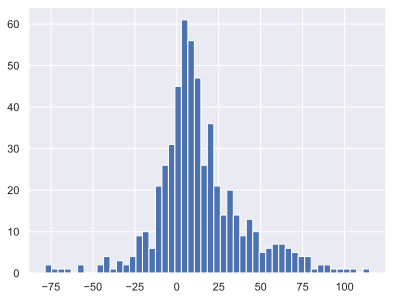

In [123]:
errSpeed = dfN.movSpeed - dfN.tapSpeed
plt.hist(errSpeed,bins=50)

Text(0.5, 1.0, 'start drag time as a function of angle error')

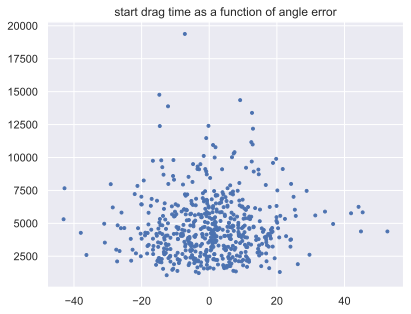

In [124]:
fig, ax = plt.subplots()
ax.plot(errAngle, dfN.tapHor-dfN.movStart, '.')
ax.set_title('start drag time as a function of angle error')